In [1]:
import re
import warnings

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from natasha import Doc, MorphVocab, NewsEmbedding, NewsMorphTagger, Segmenter
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
from xgboost import XGBClassifier

nltk.download("stopwords")

warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Cristin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Загрузка датасетов и подготовка данных

In [2]:
# Загружаем курс доллара к рублю, преобразуем дату
df_time = pd.read_csv("usdrub_d.csv", parse_dates=["Date"])
df_time["date"] = df_time["Date"].dt.date

# Загружаем датасет новостей Lenta.ru и преобразуем в DataFrame
dataset = load_dataset("data-silence/lenta.ru_2-extended")
df = dataset["train"].to_pandas()

# Преобразуем формат даты и фильтруем по наличию тегов
df["date"] = pd.to_datetime(df["date"]).dt.date
df_filtered = df.dropna(subset=["tags"])
df_filtered = df_filtered[df_filtered["tags"].isin(["Экономика", "Политика"])]

# Объединяем заголовки новостей по дате в один текст
grouped = (
    df_filtered.groupby("date")["title"]
    .apply(lambda texts: " ".join(texts))
    .reset_index()
)

# Строим полный диапазон дат и объединяем с новостями, где нет — подставляем заглушку
full_date_range = pd.date_range(
    start=grouped["date"].min(), end=grouped["date"].max(), freq="D"
).date
df_news_full = pd.DataFrame({"date": full_date_range}).merge(
    grouped, on="date", how="left"
)
df_news_full["title"] = df_news_full["title"].fillna("нет новостей")

# Фильтруем курс по датам новостей и оставляем только дату и цену закрытия
df_time_filtered = df_time[
    df_time["date"].between(grouped["date"].min(), grouped["date"].max())
]
df_time_filtered = df_time_filtered[["date", "Close"]]

# Объединяем новости и курсы валют по дате
df_merged = pd.merge(df_news_full, df_time_filtered, on="date", how="inner")

# Добавляем целевую переменную: 1, если курс вырос на следующий день
df_merged["target"] = (df_merged["Close"].shift(-1) > df_merged["Close"]).astype(int)

# Оставляем только нужные столбцы
df_final = df_merged[["date", "title", "Close", "target"]]

# Преобразуем дату обратно в формат datetime
df_final["date"] = pd.to_datetime(df_final["date"])

In [3]:
df_final.head()

,date,title,Close,target
0,2019-12-16,Пентагон ответил на слова Эрдогана о закрытии ...,62.4369,0
1,2019-12-17,В российском регионе одобрили разработку калий...,62.4170,1
2,2019-12-18,Глава Генштаба оценил вероятность начала крупн...,62.5908,0
3,2019-12-19,Путин назвал подвигом жизнь россиян в 1990-х П...,62.3800,0
4,2019-12-20,Италия решила выдать США арестованного российс...,62.2736,0


In [5]:
print(df_final["target"].value_counts(normalize=True).rename(lambda x: f"class {x}"))

target
class 0    0.50391
class 1    0.49609
Name: proportion, dtype: float64


In [4]:
counts = df_final["target"].value_counts()
percent = df_final["target"].value_counts(normalize=True).round(3)
balance_df = pd.DataFrame({"count": counts, "percent": percent})
print(balance_df)

        count  percent
target                
0         580    0.504
1         571    0.496


## Функция для метрик

In [ ]:
def evaluate_classifier_metrics(y_true, y_pred, y_score=None):
    """
    Выводит classification report и график ROC-кривой (если y_score передан).

    Parameters:
    - y_true : array-like — истинные метки классов (0 или 1)
    - y_pred : array-like — предсказанные метки классов (0 или 1)
    - y_score : array-like or None — оценки уверенности модели (например, вероятности)
    """

    # Печатаем сводку метрик классификации (precision, recall, f1 и т.д.)
    print("📋 Classification Report:\n")
    print(classification_report(y_true, y_pred, digits=3))

    # Если передан y_score, строим ROC-кривую и вычисляем AUC
    if y_score is not None:
        fpr, tpr, _ = roc_curve(y_true, y_score)  # координаты ROC-кривой
        auc_score = roc_auc_score(y_true, y_score)  # площадь под кривой (AUC)

        # Отрисовка графика
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.3f}")
        plt.plot([0, 1], [0, 1], "k--", alpha=0.4)  # линия случайной модели
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("📈 ROC Curve")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Модели для временного ряда

## Arima

In [ ]:
# === Подготовка данных ===

df = df_final[["date", "Close"]].copy()  # Берем только дату и цену закрытия

df = df.rename(
    columns={"date": "ds", "Close": "y"}
)  # Переименование под формат StatsForecast
df["ds"] = pd.to_datetime(df["ds"])  # Преобразуем дату в формат datetime

# Добавляем уникальный идентификатор временного ряда (требование StatsForecast)
df["unique_id"] = "rub_usd"

# === Обучение модели ===

# Инициализация модели AutoARIMA с дневной сезонностью и параллельной обработкой
model = StatsForecast(models=[AutoARIMA(season_length=5)], freq="D", n_jobs=-1)

# Кросс-валидация: прогнозируем на один день вперед по скользящему окну, не переобучаясь
cv_df = model.cross_validation(
    df=df,
    h=1,  # горизонта прогноза: 1 день
    step_size=1,  # шаг окна: 1 день
    test_size=200,  # длина тестовой выборки: 200 дней
    refit=False,  # модель не переобучается на каждом окне
)

📋 Classification Report:

              precision    recall  f1-score   support

           0      0.469     0.430     0.449       107
           1      0.396     0.435     0.415        92

    accuracy                          0.432       199
   macro avg      0.433     0.432     0.432       199
weighted avg      0.435     0.432     0.433       199



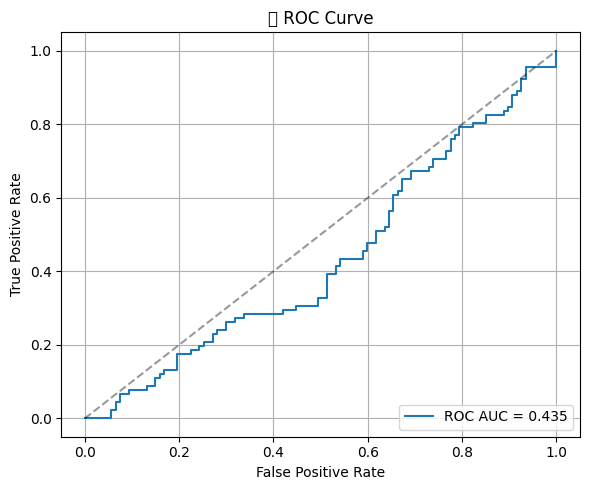

In [ ]:
# Объединяем исходные данные с прогнозами модели по дате
cv_df = df_final.merge(
    cv_df[["ds", "AutoARIMA"]], left_on=["date"], right_on=["ds"], how="left"
)

# Преобразуем прогноз в бинарную метку: 1, если прогноз выше текущей цены
cv_df["y_pred"] = (cv_df["AutoARIMA"].shift(-1) > cv_df["Close"]).astype(int)

# Оцениваем "уверенность" модели — разница между прогнозом и текущей ценой
cv_df["y_score"] = cv_df["AutoARIMA"].shift(-1) - cv_df["Close"]

# Удаляем последнюю строку с пропущенным значением целевой переменной
cv_clean = cv_df.dropna()

# Выводим метрики классификации и ROC-кривую для оценки модели
evaluate_classifier_metrics(
    y_true=cv_clean["target"], y_pred=cv_clean["y_pred"], y_score=cv_clean["y_score"]
)

### Подготовка для моделей ML классификации 

In [ ]:
# Копируем исходный датафрейм с ценой и целевой переменной
df_time = df_final[["Close", "target"]].copy()

# Добавляем лаги: текущая, вчерашняя и позавчерашняя цена
df_time["lag_1"] = df_time["Close"]
df_time["lag_2"] = df_time["Close"].shift(1)
df_time["lag_3"] = df_time["Close"].shift(2)

# Скользящее среднее за последние 5 дней
df_time["sma_5"] = df_time["Close"].rolling(window=5).mean()

# Изменение курса за последнюю неделю (5 дней)
df_time["delta_week"] = df_time["Close"] - df_time["Close"].shift(5)

# Удаляем строки с пропущенными значениями, возникшими из-за лагов и скользящего среднего
df_time = df_time.dropna().reset_index(drop=True)

# Выводим полученный датафрейм
display(df_time)

# Определяем признаки и целевую переменную для обучения модели
X = df_time[["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]]
y = df_time["target"]

,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week
0,62.2455,0,62.2455,62.2736,62.3800,62.38138,-0.1914
1,61.9863,1,61.9863,62.2455,62.2736,62.29524,-0.4307
2,62.2286,0,62.2286,61.9863,62.2455,62.22280,-0.3622
3,62.1020,0,62.1020,62.2286,61.9863,62.16720,-0.2780
4,61.9750,1,61.9750,62.1020,62.2286,62.10748,-0.2986
...,...,...,...,...,...,...,...
1141,87.4500,1,87.4500,89.0000,87.1850,86.72700,-1.5750
1142,87.7750,0,87.7750,87.4500,89.0000,86.98200,1.2750
1143,87.2500,0,87.2500,87.7750,87.4500,87.73200,3.7500
1144,86.5000,0,86.5000,87.2500,87.7750,87.59500,-0.6850


In [ ]:
def train_and_evaluate_classifier(
    X, y, model_name="logreg", n_test=200, scale=True, random_state=42
):
    # Разделяем данные на обучающую и тестовую выборки по временной оси
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и подбор параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Сборка пайплайна: масштабирование признаков (если указано) + классификатор
    steps = []
    if scale:
        steps.append(("scaler", StandardScaler()))
    steps.append(("clf", model))
    pipe = Pipeline(steps)

    # Поиск лучших параметров с помощью кросс-валидации
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности на тестовой выборке
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Выводим лучшие параметры и оцениваем метрики модели
    print(f"🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## Логистическая регрессия

🔧 Best parameters for logreg: {'clf__C': 1, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.520     0.833     0.641       108
           1      0.333     0.098     0.151        92

    accuracy                          0.495       200
   macro avg      0.427     0.466     0.396       200
weighted avg      0.434     0.495     0.415       200



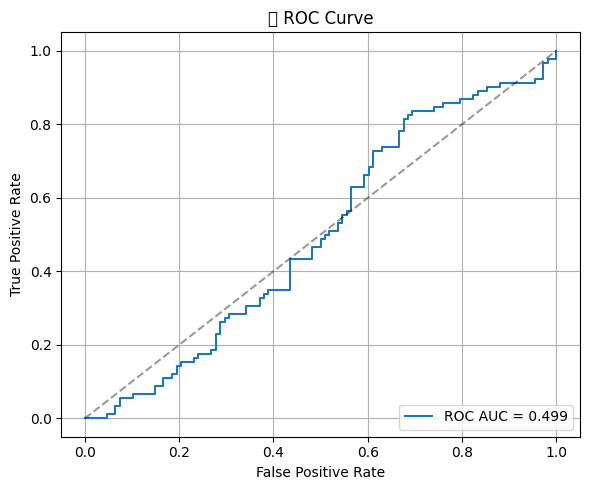

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [ ]:
# Обучаем и оцениваем логистическую регрессию на выбранных признаках
train_and_evaluate_classifier(X, y, model_name="logreg")

## Random Forest

🔧 Best parameters for rf: {'clf__max_depth': 3, 'clf__n_estimators': 500}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.529     0.333     0.409       108
           1      0.455     0.652     0.536        92

    accuracy                          0.480       200
   macro avg      0.492     0.493     0.472       200
weighted avg      0.495     0.480     0.467       200



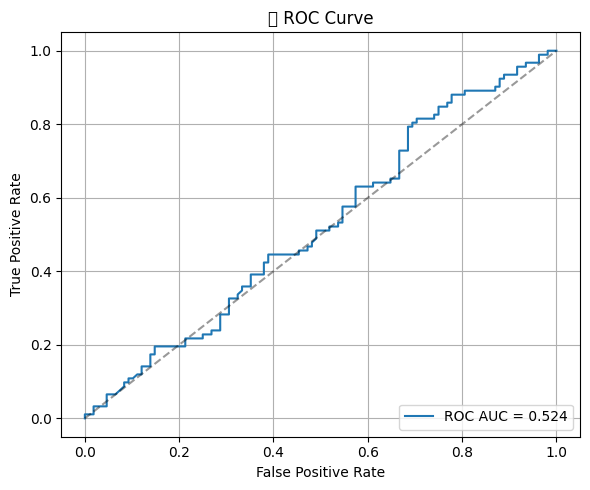

Pipeline(steps=[('clf',
                 RandomForestClassifier(max_depth=3, n_estimators=500,
                                        random_state=42))])

In [ ]:
# Обучаем и оцениваем модель случайного леса (масштабирование не требуется)
train_and_evaluate_classifier(X, y, model_name="rf", scale=False)

## XGBoost

🔧 Best parameters for xgb: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 1000}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.574     0.250     0.348       108
           1      0.471     0.783     0.588        92

    accuracy                          0.495       200
   macro avg      0.523     0.516     0.468       200
weighted avg      0.527     0.495     0.458       200



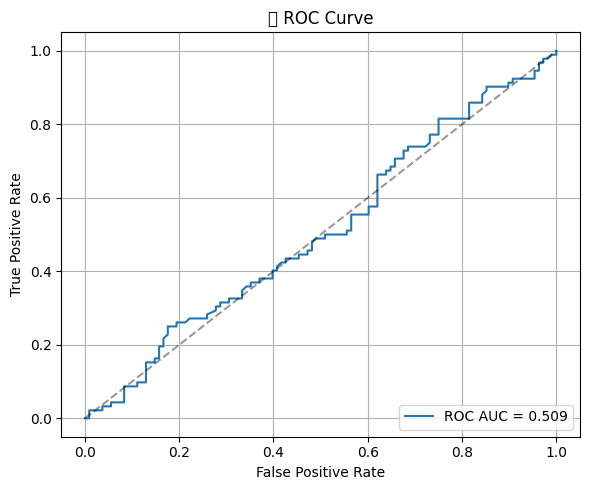

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Обучаем и оцениваем модель XGBoost (без масштабирования признаков)
train_and_evaluate_classifier(X, y, model_name="xgb", scale=False)

# Модели для новостей

### Подготовка для текстовых моделей

In [ ]:
# === Предобработка текста (лемматизация на русском через Natasha) ===
segmenter = Segmenter()  # Разделяет текст на предложения и токены
emb = NewsEmbedding()  # Эмбеддинги для новостных текстов
morph_tagger = NewsMorphTagger(emb)  # Определяет часть речи и морфологические признаки
morph_vocab = MorphVocab()  # Используется для лемматизации
stop_words = set(stopwords.words("russian"))  # Русские стоп-слова из NLTK


# === Функция предобработки текста ===
def preprocess_text(text):
    # Приводим к нижнему регистру и удаляем всё, кроме русских букв и пробелов
    text = re.sub(r"[^а-яёА-ЯЁ\\s]", " ", text.lower())

    # Обрабатываем текст с помощью Natasha
    doc = Doc(text)
    doc.segment(segmenter)  # Токенизация
    doc.tag_morph(morph_tagger)  # Морфологическая разметка

    lemmas = []
    for token in doc.tokens:
        # Лемматизируем, если у токена есть морфология
        if token.pos and token.feats:
            lemma = morph_vocab.lemmatize(token.text, token.pos, token.feats)
            # Убираем стоп-слова и слишком короткие леммы
            if lemma not in stop_words and len(lemma) > 2:
                lemmas.append(lemma)

    # Возвращаем текст из лемм
    return " ".join(lemmas)

In [ ]:
# Выбираем заголовки новостей и целевую переменную
df_news = df_final[["title", "target"]]

# Применяем предобработку к заголовкам: очистка и лемматизация
df_news["clean_title"] = df_news["title"].apply(preprocess_text)

# Просматриваем первые строки полученного датафрейма
df_news.head()

C:\Users\RobotComp.ru\AppData\Local\Temp\ipykernel_10840\1371736760.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news["clean_title"] = df_news["title"].apply(preprocess_text)


,title,target,clean_title
0,Пентагон ответил на слова Эрдогана о закрытии ...,0,пентагон ответить слово эрдоган закрытие военн...
1,В российском регионе одобрили разработку калий...,1,российский регион одобрить разработка калийный...
2,Глава Генштаба оценил вероятность начала крупн...,0,глава генштаб оценить вероятность начало крупн...
3,Путин назвал подвигом жизнь россиян в 1990-х П...,0,путин назвать подвиг жизнь россиянин путин отв...
4,Италия решила выдать США арестованного российс...,0,италия решить выдать сша арестовать российский...


In [ ]:
# === Инициализация токенизатора и модели BERT от Sberbank ===
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")
model = AutoModel.from_pretrained("sberbank-ai/ruBert-base")
model.eval()  # Переводим модель в режим инференса (без градиентов)


# === Функция для кодирования длинных текстов чанками ===
def bert_encode_long(texts, max_len=512, stride=256):
    vectors = []
    with torch.no_grad():  # Отключаем градиенты для ускорения и экономии памяти
        for text in tqdm(texts, desc="BERT long embedding"):
            # Токенизация без усечения
            tokens = tokenizer(text, return_tensors="pt", truncation=False)[
                "input_ids"
            ][0]
            # Делим токены на перекрывающиеся чанки
            chunks = [tokens[i : i + max_len] for i in range(0, len(tokens), stride)]
            chunk_vecs = []
            for chunk in chunks:
                input_ids = chunk.unsqueeze(0)
                attention_mask = torch.ones_like(
                    input_ids
                )  # Маска внимания без паддинга
                output = model(input_ids=input_ids, attention_mask=attention_mask)
                cls = output.last_hidden_state[:, 0, :].squeeze().numpy()  # [CLS] токен
                chunk_vecs.append(cls)
            # Усредняем вектор по чанкам
            avg_vector = np.mean(chunk_vecs, axis=0)
            vectors.append(avg_vector)
    return np.array(vectors)


# Применяем кодирование к очищенным заголовкам
bert_vectors = bert_encode_long(df_news["clean_title"].tolist())
bert_vectors

# Сохраняем эмбеддинги в датафрейм и объединяем с исходными данными
df_bert = pd.DataFrame(bert_vectors)
df_news = df_news.reset_index(drop=True).join(df_bert)

BERT long embedding: 100%|██████████| 1151/1151 [15:34<00:00,  1.23it/s]


In [ ]:
df_news.head()

,title,target,clean_title,0,1,2,3,4,5,6,...,758,759,760,761,762,763,764,765,766,767
0,Пентагон ответил на слова Эрдогана о закрытии ...,0,пентагон ответить слово эрдоган закрытие военн...,0.997813,0.454933,0.658045,-0.153712,0.050290,0.198508,-0.022404,...,-0.602833,-0.585575,-1.039935,0.129338,-0.647122,-0.072675,0.224441,0.607684,0.565845,-0.220322
1,В российском регионе одобрили разработку калий...,1,российский регион одобрить разработка калийный...,0.985951,0.574889,0.356109,0.449614,-0.334680,0.108759,0.333026,...,-0.277030,-0.492331,-0.933529,0.673872,-0.686468,0.322012,0.242555,0.649013,0.785023,0.072742
2,Глава Генштаба оценил вероятность начала крупн...,0,глава генштаб оценить вероятность начало крупн...,0.927387,0.657644,0.662591,0.198693,-0.177160,0.347345,-0.042794,...,-0.348206,-0.360314,-0.795399,-0.034558,-0.858139,0.126719,0.313325,0.710700,0.629864,0.266698
3,Путин назвал подвигом жизнь россиян в 1990-х П...,0,путин назвать подвиг жизнь россиянин путин отв...,0.665235,0.556451,0.200274,0.617243,-0.221813,0.364381,0.346314,...,-0.152317,-0.257469,-0.794252,0.203919,-0.455761,-0.013108,0.052784,0.585324,0.525603,0.319815
4,Италия решила выдать США арестованного российс...,0,италия решить выдать сша арестовать российский...,0.980714,0.586150,0.276275,0.144118,-0.098954,-0.037860,0.299156,...,-0.380686,-0.460258,-0.729558,0.103069,-0.710490,0.200725,0.306790,0.757566,0.949913,0.324324


### Функция для моделей

In [ ]:
# === Универсальная функция обучения модели — поддерживает TF-IDF и BERT-вектора ===
def train_and_evaluate_classifier(
    df, model_name="logreg", use_bert=False, n_test=200, scale=True, random_state=42
):
    # Выбор признаков: либо BERT-вектора (768 признаков), либо текст для TF-IDF
    if use_bert:
        X = df.iloc[:, -768:]  # Используем последние 768 колонок как эмбеддинги
    else:
        X = df["clean_title"]  # Используем текст для TF-IDF

    # Целевая переменная
    y = df["target"]

    # Делим данные на обучающую и тестовую выборки по времени
    X_train, X_test = X[:-n_test], X[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и сетки параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Сборка пайплайна:
    # для TF-IDF добавляем векторизацию, для BERT — масштабирование (по желанию)
    steps = []
    if not use_bert:
        steps.append(("tfidf", TfidfVectorizer()))
    elif scale:
        steps.append(("scaler", StandardScaler()))

    steps.append(("clf", model))
    pipe = Pipeline(steps)

    # Обучение модели с подбором параметров
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности для тестовой выборки
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Вывод лучших параметров и метрик модели
    print(f"\n🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## TF-IDF + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 0.01, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       108
           1      0.460     1.000     0.630        92

    accuracy                          0.460       200
   macro avg      0.230     0.500     0.315       200
weighted avg      0.212     0.460     0.290       200



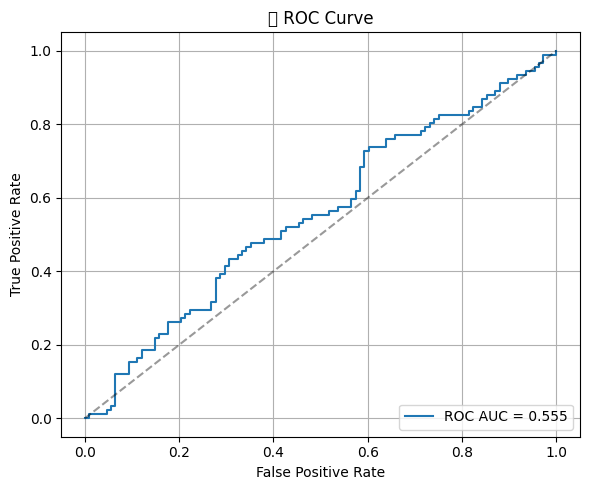

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(C=0.01, max_iter=1000, random_state=42))])

In [ ]:
# Обучаем логистическую регрессию на TF-IDF векторах заголовков
train_and_evaluate_classifier(df_news, model_name="logreg")

## BERT + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 10, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.545     0.556     0.550       108
           1      0.467     0.457     0.462        92

    accuracy                          0.510       200
   macro avg      0.506     0.506     0.506       200
weighted avg      0.509     0.510     0.510       200



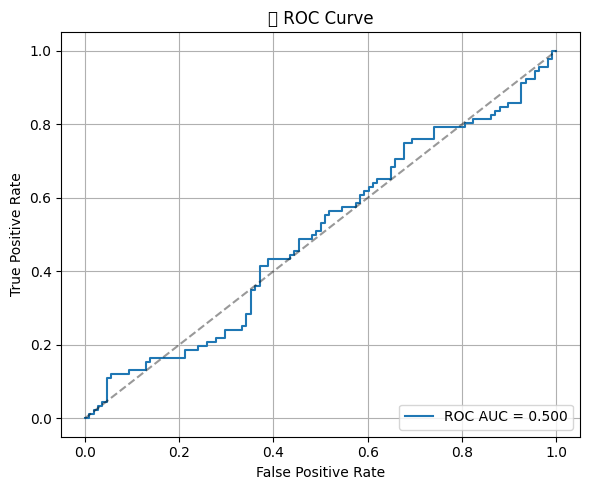

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

In [ ]:
# Обучаем логистическую регрессию на BERT-векторах заголовков
train_and_evaluate_classifier(df_news, model_name="logreg", use_bert=True)

## TF-IDF + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 5, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.525     0.287     0.371       108
           1      0.454     0.696     0.549        92

    accuracy                          0.475       200
   macro avg      0.490     0.491     0.460       200
weighted avg      0.493     0.475     0.453       200



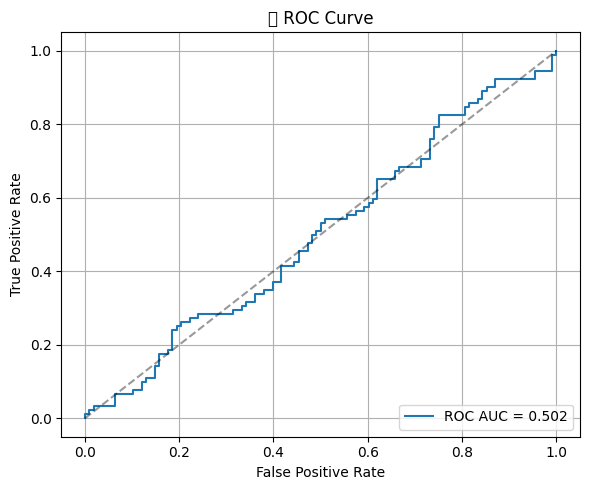

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier(max_depth=5, random_state=42))])

In [ ]:
# Обучаем модель случайного леса на TF-IDF векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="rf", scale=False)

## BERT + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 10, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.614     0.472     0.534       108
           1      0.513     0.652     0.574        92

    accuracy                          0.555       200
   macro avg      0.564     0.562     0.554       200
weighted avg      0.568     0.555     0.552       200



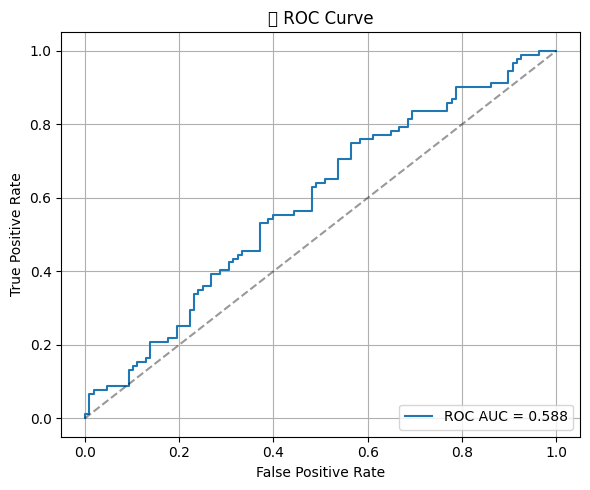

Pipeline(steps=[('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
# Обучаем модель случайного леса на BERT-векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="rf", use_bert=True, scale=False)

## TF-IDF + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 1000}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.564     0.407     0.473       108
           1      0.475     0.630     0.542        92

    accuracy                          0.510       200
   macro avg      0.520     0.519     0.508       200
weighted avg      0.523     0.510     0.505       200



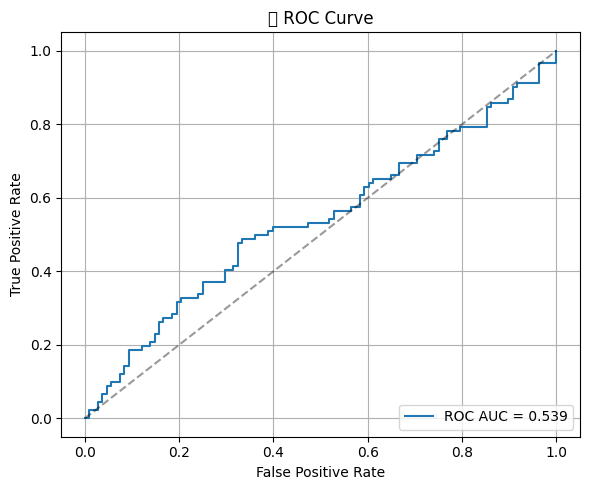

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Обучаем модель XGBoost на TF-IDF векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="xgb", scale=False)

## BERT + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.540     0.565     0.552       108
           1      0.460     0.435     0.447        92

    accuracy                          0.505       200
   macro avg      0.500     0.500     0.499       200
weighted avg      0.503     0.505     0.504       200



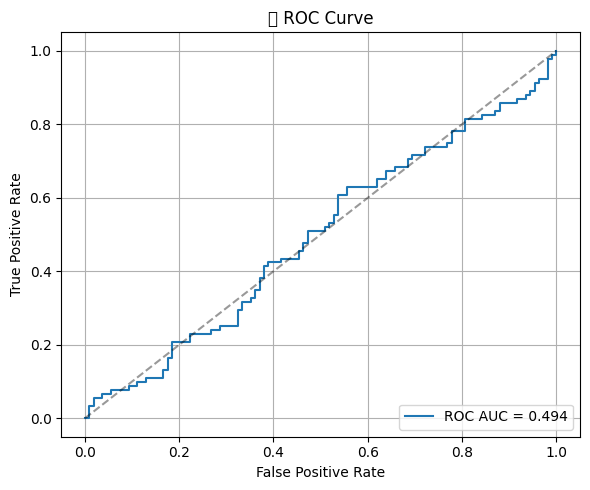

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Обучаем модель XGBoost на BERT-векторах (масштабирование не требуется)
train_and_evaluate_classifier(df_news, model_name="xgb", use_bert=True, scale=False)

# Мультимодальные модели

In [ ]:
# Объединяем временные признаки (лаговые и SMA) с текстовыми признаками из новостей
# Пропускаем первые 5 строк в новостях — они были отброшены ранее из-за расчётов скользящих метрик
df_time_news = df_time.join(df_news.loc[5:, "clean_title":].reset_index(drop=True))

# Приводим имена всех колонок к строковому типу (нужно, если были числовые индексы)
df_time_news.columns = df_time_news.columns.astype(str)

# Просматриваем первые строки итогового датафрейма
df_time_news.head()

,Close,target,lag_1,lag_2,lag_3,sma_5,delta_week,clean_title,0,1,...,758,759,760,761,762,763,764,765,766,767
0,62.2455,0,62.2455,62.2736,62.3800,62.38138,-0.1914,турция остаться недовольный приговор дело хашк...,0.838353,0.594079,...,-0.484732,-0.316418,-0.898973,0.077173,-0.675357,0.042391,0.098805,0.565121,0.697840,0.293090
1,61.9863,1,61.9863,62.2455,62.2736,62.29524,-0.4307,житель бывший столица иго впервые пообщаться р...,0.880879,0.758321,...,-0.012292,-0.669244,-1.029279,-0.001300,-0.776207,0.274373,0.313399,0.760003,0.721384,0.197988
2,62.2286,0,62.2286,61.9863,62.2455,62.22280,-0.3622,шведский пенсионер подселить мигрант житель ге...,0.822568,0.525946,...,-0.371504,-0.427340,-0.680329,-0.023301,-0.654869,-0.009134,0.182150,0.748722,0.762243,0.169308
3,62.1020,0,62.1020,62.2286,61.9863,62.16720,-0.2780,саратовский область вырасти финансирование под...,0.694989,0.579582,...,-0.531898,-0.599320,-1.126621,0.277093,-0.712261,0.170290,0.266504,0.841565,0.830382,0.122629
4,61.9750,1,61.9750,62.1020,62.2286,62.10748,-0.2986,сша ответить слово путин виновник второй миров...,1.113546,1.010703,...,-0.245520,-0.481420,-0.615766,0.396128,-0.301226,0.477590,0.059829,0.796225,0.880844,-0.009917


In [ ]:
# === Обучение мультимодальной модели: текст (TF-IDF/BERT) + числовые признаки ===
def train_multimodal_classifier(
    df, model_name="logreg", use_bert=False, n_test=200, random_state=42
):
    text_col = "clean_title"  # Название колонки с текстом
    num_cols = ["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]  # Числовые признаки

    y = df["target"]  # Целевая переменная

    # Разделяем текстовую часть на train/test
    if use_bert:
        X_text = df.iloc[:, -768:]  # Если BERT — используем последние 768 колонок
        X_text_train, X_text_test = X_text[:-n_test], X_text[-n_test:]
    else:
        X_text = df[[text_col]]  # Если TF-IDF — оставляем текстовую колонку
        X_text_train, X_text_test = X_text[:-n_test], X_text[-n_test:]

    # Разделяем числовые признаки на train/test
    X_num = df[num_cols]
    X_num_train, X_num_test = X_num[:-n_test], X_num[-n_test:]
    y_train, y_test = y[:-n_test], y[-n_test:]

    # Выбор модели и сетки параметров для GridSearch
    if model_name == "logreg":
        model = LogisticRegression(max_iter=1000, random_state=random_state)
        param_grid = {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10, 100]}
    elif model_name == "rf":
        model = RandomForestClassifier(random_state=random_state)
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5, 10],
        }
    elif model_name == "xgb":
        model = XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=random_state
        )
        param_grid = {
            "clf__n_estimators": [100, 200, 500, 1000],
            "clf__max_depth": [3, 5],
            "clf__learning_rate": [0.01, 0.1],
        }
    else:
        raise ValueError("Модель должна быть одной из: 'logreg', 'rf', 'xgb'")

    # Обработка признаков для BERT: числовые — масштабируем, текстовые — как есть
    if use_bert:
        preprocessor = ColumnTransformer(
            [("num", StandardScaler(), num_cols)], remainder="passthrough"
        )
        X_train = pd.concat(
            [X_text_train.reset_index(drop=True), X_num_train.reset_index(drop=True)],
            axis=1,
        )
        X_test = pd.concat(
            [X_text_test.reset_index(drop=True), X_num_test.reset_index(drop=True)],
            axis=1,
        )
    else:
        # Обработка TF-IDF + масштабирование числовых признаков
        text_transformer = Pipeline([("tfidf", TfidfVectorizer())])
        num_transformer = Pipeline([("scaler", StandardScaler())])

        preprocessor = ColumnTransformer(
            [("text", text_transformer, text_col), ("num", num_transformer, num_cols)]
        )

        X_train = pd.concat([X_text_train, X_num_train], axis=1)
        X_test = pd.concat([X_text_test, X_num_test], axis=1)

    # Сборка полного пайплайна: препроцессор + классификатор
    pipe = Pipeline([("preprocessor", preprocessor), ("clf", model)])

    # Поиск лучших параметров и обучение модели
    grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
    grid.fit(X_train, y_train)

    # Предсказания и вероятности
    y_pred = grid.best_estimator_.predict(X_test)
    y_score = grid.best_estimator_.predict_proba(X_test)[:, 1]

    # Вывод лучших параметров и метрик
    print(f"\n🔧 Best parameters for {model_name}:", grid.best_params_)
    evaluate_classifier_metrics(y_test, y_pred, y_score)

    return grid.best_estimator_

## TF-IDF + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 1, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.565     0.769     0.651       108
           1      0.528     0.304     0.386        92

    accuracy                          0.555       200
   macro avg      0.546     0.536     0.519       200
weighted avg      0.548     0.555     0.529       200



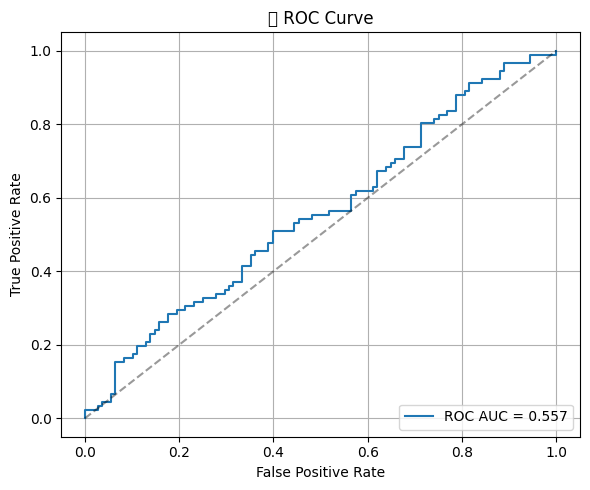

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 LogisticRegression(C=1, max_iter=1000, random_state=42))])

In [ ]:
# Обучаем логистическую регрессию на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="logreg")

## BERT + Логистическая регрессия


🔧 Best parameters for logreg: {'clf__C': 10, 'clf__penalty': 'l2'}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.552     0.685     0.612       108
           1      0.485     0.348     0.405        92

    accuracy                          0.530       200
   macro avg      0.519     0.517     0.508       200
weighted avg      0.521     0.530     0.517       200



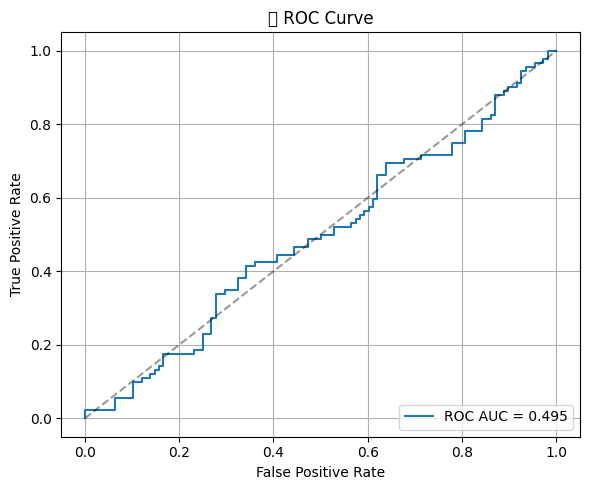

C:\Users\RobotComp.ru\AppData\Roaming\Python\Python311\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 LogisticRegression(C=10, max_iter=1000, random_state=42))])

In [ ]:
# Обучаем логистическую регрессию на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="logreg", use_bert=True)

## TF-IDF + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 10, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.565     0.324     0.412       108
           1      0.471     0.707     0.565        92

    accuracy                          0.500       200
   macro avg      0.518     0.515     0.488       200
weighted avg      0.522     0.500     0.482       200



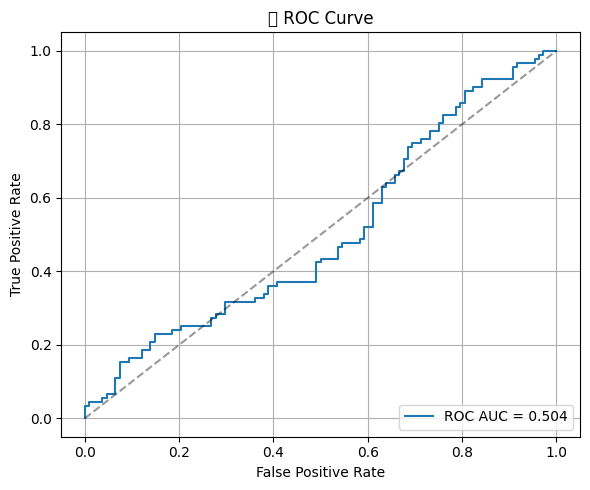

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf', RandomForestClassifier(max_depth=10, random_state=42))])

In [ ]:
# Обучаем модель случайного леса на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="rf")

## BERT + Random Forest


🔧 Best parameters for rf: {'clf__max_depth': 3, 'clf__n_estimators': 200}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.600     0.306     0.405       108
           1      0.483     0.761     0.591        92

    accuracy                          0.515       200
   macro avg      0.541     0.533     0.498       200
weighted avg      0.546     0.515     0.490       200



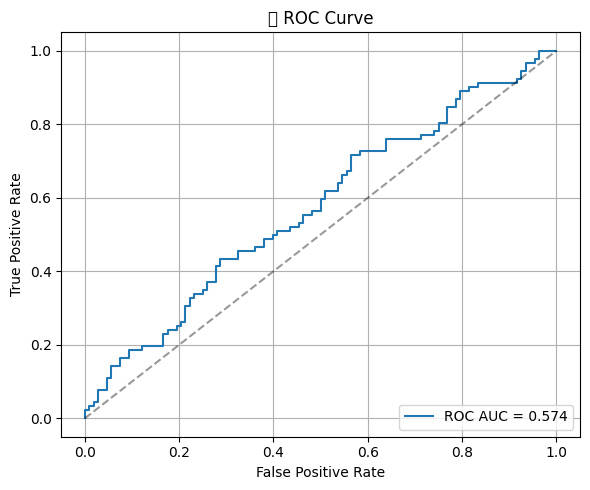

C:\Users\RobotComp.ru\AppData\Roaming\Python\Python311\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 RandomForestClassifier(max_depth=3, n_estimators=200,
                                        random_state=42))])

In [ ]:
# Обучаем модель случайного леса на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="rf", use_bert=True)

## TF-IDF + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.524     0.407     0.458       108
           1      0.448     0.565     0.500        92

    accuracy                          0.480       200
   macro avg      0.486     0.486     0.479       200
weighted avg      0.489     0.480     0.477       200



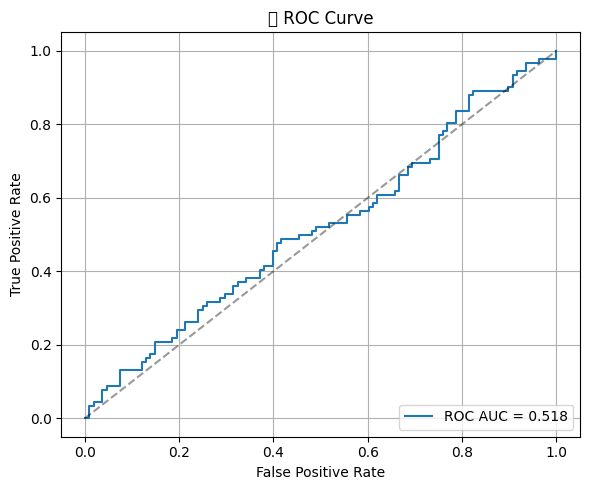

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer())]),
                                                  'clean_title'),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               col...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
# Обучаем модель XGBoost на TF-IDF + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="xgb")

## BERT + XGBoost


🔧 Best parameters for xgb: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100}
📋 Classification Report:

              precision    recall  f1-score   support

           0      0.584     0.481     0.528       108
           1      0.495     0.598     0.542        92

    accuracy                          0.535       200
   macro avg      0.540     0.540     0.535       200
weighted avg      0.543     0.535     0.534       200



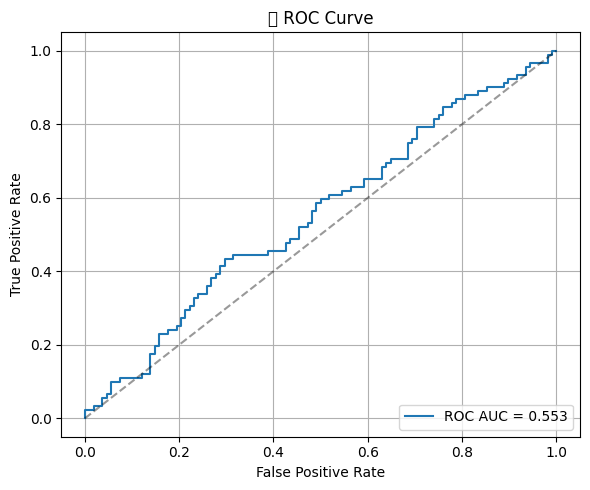

C:\Users\RobotComp.ru\AppData\Roaming\Python\Python311\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'sma_5', 'delta_week'])])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categoric...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [30]:
# Обучаем модель XGBoost на BERT-векторах + числовых признаках (мультимодальная модель)
train_multimodal_classifier(df_time_news, model_name="xgb", use_bert=True)